In [1]:
%load_ext autoreload
%autoreload 2
%autosave 180

Autosaving every 180 seconds


In [2]:
import numpy as np
import torch
import pickle

import dgl

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.nn.functional import binary_cross_entropy_with_logits as BCELoss
from torch.utils.data import DataLoader
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from sklearn.metrics import precision_score,recall_score,f1_score
import torch.nn as nn
import os
import networkx as nx
import json

device = "cuda"

np.random.seed(0)
torch.manual_seed(0)

model_predictor = "agent"

Using backend: pytorch


In [23]:
import itertools
print('Loading data')
path = '/media/panagiotis/TOSHIBA EXT1/Research/Novelty_detection/datasets/gridworlds_data/novelgridworlds_no_nov_1_easy/normal_graphs_maps.pkl'
with open(path, 'rb') as f:
    graphs,maps = pickle.load(f)


path = '/media/panagiotis/TOSHIBA EXT1/Research/Novelty_detection/datasets/gridworlds_data/novelgridworlds_no_nov_1_easy/normal_nodeids.pkl'
with open(path, 'rb') as f:
    node_ids = pickle.load(f)

from Dataset import *

data = Dataset(graphs,maps)
batch_size = 100

train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, collate_fn = my_collate)

Loading data


In [24]:
len(data)

4408

In [42]:
print('Loading data')
#path = '/media/panagiotis/TOSHIBA EXT1/Research/Novelty_detection/datasets/gridworlds_data/novelgridworlds_axe_1_hard/novel_graphs_maps.pkl'
path = '/media/panagiotis/TOSHIBA EXT1/Research/Novelty_detection/datasets/gridworlds_data/test_data/valid/valid_graphs_maps.pkl'
with open(path, 'rb') as f:
    nov_graphs,nov_maps = pickle.load(f)


#path = '/media/panagiotis/TOSHIBA EXT1/Research/Novelty_detection/datasets/gridworlds_data/novelgridworlds_axe_1_hard/novel_nodeids.pkl'
path = '/media/panagiotis/TOSHIBA EXT1/Research/Novelty_detection/datasets/gridworlds_data/test_data/valid/valid_nodeids.pkl'
with open(path, 'rb') as f:
    nov_node_ids = pickle.load(f)

from Dataset import *
test_data = Dataset(nov_graphs,nov_maps, ids =  nov_node_ids)
targets = test_data.make_targets_from_ids()
test_data.y = targets
valid_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False, collate_fn = my_collate)

Loading data


True

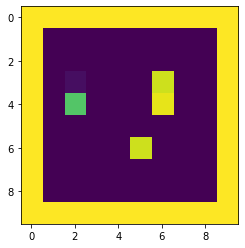

In [43]:
plt.imshow((maps[0][0]+1)/26)
#%pip install opencv-python
import cv2 as cv

cv.imwrite("map.png",((maps[0][0]+1)/26)*255)

# Model Definition

In [44]:

def _build3DMap(mp, graph_representations,graph_emb_size, batch_num_nodes):
    
    #doing the loop on cpu is actually faster
    rep_map = torch.zeros((*mp.shape,graph_emb_size)).to('cpu').float()
        
    agent_representations = torch.zeros((mp.shape[0], 64+graph_emb_size)).to('cpu')
    agent_representations_original = torch.zeros((mp.shape[0], graph_emb_size)).to('cpu')
    graph_start_index = 0
    graph_representations = graph_representations.to('cpu')

    for k in range(mp.shape[0]):  # This may be inefficient but I found no better way to construct the 3D maps. 
        
        elements=  torch.unique(mp[k])
        rep_map_k = torch.zeros(rep_map[k].shape).to('cpu')
        for e in elements:
            if e != -1: 
                
                v = graph_representations[graph_start_index+e.int()]
                rep_map_k[mp[k]==e]=v.float()
                
                if e==0:
                    agent_representations_original[k] = v

        rep_map[k] =rep_map_k
        
        graph_start_index+=batch_num_nodes[k]
            

    return rep_map,agent_representations_original, agent_representations

In [45]:

from dgl.nn import GraphConv



class MapGraphModel(torch.nn.Module):
    def __init__(self, graph_x_size, graph_emb_size, output_size = 1):
        super(MapGraphModel, self).__init__()
        self.graph_emb_size = graph_emb_size
        
        self.agent_layer = nn.Sequential(nn.Linear((64+graph_emb_size)*2, 32), nn.ReLU(True), nn.Linear(32,1)) # layer to process agent representations and predict novelty

        # GCN layers for graph
        self.GCN1 = GraphConv(graph_x_size,graph_x_size, norm='both', weight=True, bias=False)
        self.GCN2 = GraphConv(graph_x_size,graph_x_size, norm='both', weight=True, bias=False)
        self.GCN3 = GraphConv(graph_x_size,self.graph_emb_size, norm='both', weight=True, bias=False)

        #CNN layers for Map
        self.Conv = torch.nn.Sequential(*[nn.Conv2d(graph_emb_size,256,kernel_size = 3, stride = 1,padding = 1),
                                        nn.ReLU(True),
                                        nn.Dropout(),
                                        nn.Conv2d(256,128,kernel_size = 3, stride = 1,padding = 1),
                                        nn.ReLU(True),
                                        nn.Dropout(),
                                        nn.Conv2d(128,64,kernel_size = 3, stride = 1,padding = 1),
                                         nn.Tanh(),
                                                                                 
                                        ])
        #Last activation function
        self.last_activation = torch.nn.functional.sigmoid if  output_size == 1 else torch.nn.functional.softmax

        #CNN to process the maps of two adjacent timesteps and predict novelty. 
        self.DiffConv = torch.nn.Sequential(*[nn.Conv2d(64*2,32,kernel_size = 3, stride = 1,padding = 0),
                                         nn.ReLU(True),
                                         nn.Dropout(),
                                         nn.Conv2d(32,16,kernel_size = 4, stride = 2,padding = 1),
                                         nn.ReLU(True),
                                         nn.Dropout(),
                                         nn.Conv2d(16,8,kernel_size = 4, stride = 2,padding = 1),
                                         nn.ReLU(True),
                                         nn.Conv2d(8,output_size,kernel_size = 4, stride = 2,padding = 1)
                                        ])

        self.device = "cuda"

    def message_pass(self, g,features): #GCN helper function
        x = features
        for layer in self.GCN:
            if type(layer).__name__ == "function":
                x = layer(x)
            else:
                x = layer(g,x)
        return x

    

    def _process_step(self,g,mp): # Processes individual steps to produce relational and spatial representations
        
        g = g.to(self.device)
        
        x = g.ndata["h"]
        
        x = self.GCN1(g,x)
        x = torch.nn.functional.relu(x)
        x = self.GCN2(g,x)
        x = torch.nn.functional.relu(x)
        x = self.GCN3(g,x)
        x = torch.nn.functional.tanh(x)
        graph_representations = x


        batch_num_nodes = g.batch_num_nodes()
    
        rep_map,agent_representations_original, agent_representations = _build3DMap(mp, graph_representations,self.graph_emb_size,batch_num_nodes)
        rep_map = rep_map.permute(0,3,1,2)   
        
        if self.device!='cpu':

            rep_map = rep_map.to(self.device)
            agent_representations= agent_representations.to(self.device)
            agent_representations_original = agent_representations_original.to(self.device)

        rep_map = self.Conv(rep_map)
        


        for k in range(mp.shape[0]):
            v = torch.transpose(rep_map[k][:,mp[k]==0], 0 , 1)
            u = torch.reshape(agent_representations_original[k],(1,self.graph_emb_size))
            
            agent_representations[k] = torch.cat([v,u],1)


        return rep_map, agent_representations

    def forward(self,steps):
        #step1,step2 = steps
        g1,m1,g2,m2 = steps

        rep_map_1, agent_representations_1 = self._process_step(g1,m1) # process step t
        rep_map_2, agent_representations_2 = self._process_step(g2,m2) # process step t+1        
        res = None


        #Predict with selected predictor

        if model_predictor == "map":
            x=  torch.cat([rep_map_1,rep_map_2], 1)
            res = self.DiffConv(x)
            res = self.last_activation(res)
        elif model_predictor == "both":
        #both
            x =torch.cat([agent_representations_1,agent_representations_2], -1)
            agent_res = self.agent_layer(x.to(self.device))
            agent_res = torch.reshape(agent_res,(-1,1,1,1))

            x=  torch.cat([rep_map_1,rep_map_2], 1)
            res = self.DiffConv(x)
            res = (self.last_activation(res) +self.last_activation(agent_res)) /2

        elif model_predictor == "agent":
            x =torch.cat([agent_representations_1,agent_representations_2], -1)
            agent_res = self.agent_layer(x.to(self.device))
            agent_res = torch.reshape(agent_res,(-1,1,1,1))

            res = self.last_activation(agent_res)


        return res, rep_map_2




In [46]:

# Creates function that moves object e in the map
def make_move_e_action(e):
    def move_object(step):
        g,mp = step
        elements,counts =  torch.unique(mp, return_counts = True)
        original_positions = torch.nonzero(torch.where(mp==e, torch.tensor(1).to(device), torch.tensor(0).to(device)))

        tmp = range(len(original_positions))
        c = np.random.choice(tmp, size =1)
        org_pos = original_positions[c]


        candidate_positions = torch.nonzero(torch.where(mp==-1, torch.tensor(1).to(device), torch.tensor(0).to(device)))
        tmp = range(len(candidate_positions))
        c = np.random.choice(tmp, size =1)
        mv_pos = candidate_positions[c]

    
        mp[mv_pos[:,0],mv_pos[:,1]] = mp[org_pos[:,0],org_pos[:,1]]
        mp[org_pos[:,0],org_pos[:,1]] = -1
        return g,mp
    return move_object

# Creates function that adds a random recipe (edges between items) to the map. 
def add_recipe(step):
    g,mp = step
    n = g.number_of_nodes()
    
    items = list(range(18,n,1))
    size = np.random.randint(len(items))
    
    us =np.random.choice(items, size = size)
    us = torch.tensor(us)
    us = torch.tensor(us,dtype = torch.int32).to(device)

    vs = np.zeros((size,))+ (n-1)

    vs = torch.tensor(vs,dtype = torch.int32).to(device)
    
    norms = torch.ones(len(vs))
    norms = torch.tensor(norms, dtype= torch.float32).to(device)
    types = torch.tensor(torch.ones(len(vs)).to(device) + 3,dtype = torch.int32).to(device)

    g.add_edges(us,vs,  data = {"rel_type":types,  "norm": norms})
    g.add_edges(vs,us,  data = {"rel_type":types,  "norm": norms})
    
    g = dgl.add_self_loop(g)
    return (g,mp)


#Adds a new node and positions it into the world

def add_node(step):
    g,mp = step
    idx = g.number_of_nodes()
    
    idx = np.random.randint(idx,50)
    
    g.add_edges(torch.tensor([idx], dtype = torch.int32).to(device),torch.tensor([idx], dtype = torch.int32).to(device), data = {"rel_type":torch.tensor([0], dtype = torch.int32).to(device),"norm":torch.tensor([1.0], dtype = torch.float32).to(device)})
    g.add_edges(torch.tensor([idx], dtype = torch.int32).to(device),torch.tensor([0], dtype = torch.int32).to(device), data = {"rel_type":torch.tensor([1], dtype = torch.int32).to(device),"norm":torch.tensor([1.0], dtype = torch.float32).to(device)})
    #g.add_edges([0],[idx])
    g = dgl.add_self_loop(g)
    x = g.ndata['h']
    
    x[idx,idx] = 1
    g.ndata['h'] = x

    candidate_positions = torch.nonzero(torch.where(mp==-1, torch.tensor(1).to(device), torch.tensor(0).to(device)))
    
    tmp = range(len(candidate_positions))
    c = np.random.choice(tmp, size =np.random.randint(len(tmp)//2))
    
    mv_pos = candidate_positions[c]
    
    mp[mv_pos[:,0],mv_pos[:,1]] = idx
    g = g.to(device)
    mp = mp.to(device)
    n = g.number_of_nodes()
    
    return g,mp


#Creates function that adds existing item e into the map
def add_item_in_map(e):
    def add_item_e_in_map(step):
        g,mp = step

        candidate_positions = torch.nonzero(torch.where(mp==-1, torch.tensor(1).to(device), torch.tensor(0).to(device)))
        
        tmp = range(len(candidate_positions))
        c = np.random.choice(tmp, size =np.random.randint(len(tmp)//2))
        
        mv_pos = candidate_positions[c]
        
            
        mp[mv_pos[:,0],mv_pos[:,1]] = e
        g = g.to(device)
        mp = mp.to(device)
        return g,mp
    return add_item_e_in_map
    
selected_actions = []
action_list = [add_node, add_recipe,add_item_in_map(23),add_item_in_map(25)]
#action_list = [add_node, add_recipe]


class MapGraphNoveltyInjector(torch.nn.Module): # Generator for adversarial training. Computation graph gets cut somwehere between the generator and discriminator, so no gradients make it to the generator. Uses the same architecture as the discriminator to process timesteps.
    def __init__(self, graph_x_size, graph_emb_size):
        super(MapGraphNoveltyInjector, self).__init__()

        self.action_list = action_list
        self.map_graph_model = MapGraphModel(graph_x_size, graph_emb_size, output_size=len(self.action_list))


        return
    def forward(self,steps):
        action,_ = self.map_graph_model(steps)
        
        return action

class RandomGenerator(torch.nn.Module): #Random sampler of modification actions
    def __init__(self):
        super(RandomGenerator, self).__init__()


        self.action_list = action_list
        


        return
    def forward(self,steps):
        action = torch.randn(batch_size,len(self.action_list),1,1) # Select action by drawing from the uniform distribution. More than 1 action can be "turned on" and they are applied sequentially on the same state.
    
    
        return action





MapGraphNoveltyInjector(
  (map_graph_model): MapGraphModel(
    (agent_layer): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=32, out_features=1, bias=True)
      (3): Sigmoid()
    )
    (GCN1): GraphConv(in=50, out=32, normalization=both, activation=None)
    (GCN2): GraphConv(in=32, out=8, normalization=both, activation=None)
    (Conv): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Sigmoid()
    )
    (DiffConv): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Con

In [47]:
# Evaluates model given data

def validate_model(model, loader, return_data = False):
    model.eval()
    from sklearn.metrics import accuracy_score
    preds = []
    targets = []
    X = []
    for batch in loader:
        graphs1,maps1,graphs2,maps2, target = batch

        graphs1 = graphs1.to(device)
        graphs2 = graphs2.to(device)
        targets.append(target)
        maps1 = maps1.to(device)
        maps2 = maps2.to(device)
        steps = [graphs1,maps1,graphs2,maps2]
        pred, diff = model(steps)
        preds.append(pred.detach().cpu().numpy())
        X.append([graphs1.cpu(),maps1.cpu(),graphs2.cpu(),maps2.cpu()])

    targets = np.array(targets).flatten()
    preds = np.array(preds).flatten()
    y = np.round(preds)
    f1 = f1_score(targets,y)
    model.train()
    if return_data:
        return precision_score(targets,y), recall_score(targets,y), f1_score(targets,y) , accuracy_score(targets,y), X,y,preds
    return precision_score(targets,y), recall_score(targets,y), f1_score(targets,y) , accuracy_score(targets,y)

In [48]:
#Applies selected modifications to a batch of data

def make_step_modifications(action, steps):
    selected_actions.append(action)
    with torch.no_grad():
        g1,mp1,g2,mp2 = steps
        
        glist2=  dgl.unbatch(g2)
        glist1 = dgl.unbatch(g1)
        new_steps = []
        action = torch.reshape(action,(-1,len(action_list)))
        for k in range(len(mp2)):
            actions = torch.nonzero(torch.round(action[k]))
            new_step = [glist2[k], mp2[k]]
            
            if actions.size()[0] == 0:
                #if no action is above 0.5, just select the max
                actions = torch.tensor([torch.argmax(action[k],0)])
                
            
            new_step = [glist2[k], mp2[k]]
            
            for i,act in enumerate(actions):
                
                new_step = action_list[act](new_step)
                

            _g,_mp= new_step    

            new_step_k = [glist1[k],mp1[k], _g,_mp]
            new_steps.append([new_step_k,0])

        new_steps = my_collate(new_steps)
        return new_steps

# Training 

Training code for anomaly detector and "anomaly injector" (generator). Generator unused in the final report, used random sampling instead

In [49]:
imgs = []

def train_discriminator(disc, gen, batch_size,device,batch, opt_d):

    pair = []
    opt_d.zero_grad()
    
    graphs1,maps1,graphs2,maps2, real_targets = batch

    graphs1 = graphs1.to(device)
    graphs2 = graphs2.to(device)

    maps1 = maps1.to(device)
    maps2 = maps2.to(device)
    real_targets = torch.Tensor(real_targets).to(device)

    

    steps = [graphs1,maps1,graphs2,maps2]
    real_preds, im1 = disc(steps)
    pair.append(im1.detach().cpu())

    real_loss = torch.nn.functional.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    
    action = gen(steps)
    
    fake_steps = make_step_modifications(action, steps)
    
    graphs1,maps1,graphs2,maps2, fake_targets = fake_steps
    graphs1 = graphs1.to(device)
    graphs2 = graphs2.to(device)
    fake_targets = torch.zeros(len(maps2)).to(device)

    maps1 = maps1.to(device)
    maps2 = maps2.to(device)

    fake_steps = [graphs1,maps1,graphs2,maps2]
    
    
    
    fake_preds,im2 = disc(fake_steps)
    pair.append(im2.detach().cpu())
    fake_loss = torch.nn.functional.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    
    imgs.append(pair)
    total_loss = real_loss + fake_loss
    total_loss.backward()

    opt_d.step()
    return total_loss.item(), real_score, fake_score



def train_generator(gen, disc, batch_size, opt_g, batch, device):
    
    opt_g.zero_grad()

    graphs1,maps1,graphs2,maps2, real_targets = batch
    graphs1 = graphs1.to(device)
    graphs2 = graphs2.to(device)

    maps1 = maps1.to(device)
    maps2 = maps2.to(device)
    real_targets = torch.ones(len(maps2)).to(device)

    steps = [graphs1,maps1,graphs2,maps2]

    action = gen(steps)
    

    fake_steps = make_step_modifications(action, steps)
    

    graphs1,maps1,graphs2,maps2, fake_targets = fake_steps
    graphs1 = graphs1.to(device)
    graphs2 = graphs2.to(device)

    maps1 = maps1.to(device)
    maps2 = maps2.to(device)
    fake_targets = torch.zeros(len(maps2)).to(device)#torch.Tensor(fake_targets).to(device)

    fake_steps = [graphs1,maps1,graphs2,maps2]
    
    
    preds,_ = disc(fake_steps)
    
    
    
    loss = torch.nn.functional.binary_cross_entropy(preds, fake_targets)
    
    
    loss.backward()
    
    
    opt_g.step()
    
    return loss.item()




In [50]:

#Training function. Takes in Discriminator and Generator. Generator can be just a random sampler of action. 

def fit(disc, gen, train_loader,epochs, device,lr_g = 1e-4, lr_d = 1e-4, start_idx=1, run_on_valid = False, test_loader = None,batch_size = 32, model_name = "novelty_gan"):
    model_name = model_name+"_best"
    f1s = []
    torch.cuda.empty_cache()
    disc.cuda()
    gen.cuda()
    disc.train()
    gen.train()
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    best_val_f1 = -np.inf
    # Create optimizers
    opt_d = torch.optim.Adam(disc.parameters(), lr=lr_d, betas=(0.5, 0.999))
    opt_g = None
    if gen is not None and type(gen).__name__ != "RandomGenerator":
        opt_g = torch.optim.Adam(gen.parameters(), lr=lr_g, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        loss_g = 0
        loss_d = 0
        counter = 0
        real_score = 0
        fake_score = 0
        for batch in tqdm(train_loader):
            counter+=1
            
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(disc,gen,batch_size,device,batch, opt_d)
            # Train generator
            if opt_g is not None:
                for j in range(1):#if counter % 1 == 0:#for j in range(5):
                    
                    loss_g = train_generator(gen,disc,batch_size,opt_g,batch, device)
            else:
                loss_g = 0
                
                
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
        
    
        if run_on_valid:
            precision, recall,f1,score = validate_model(disc,test_loader)
            if f1>best_val_f1:
                  best_val_f1 = f1
                  torch.save(gen.state_dict(),os.path.join("./models",model_name+"_generator.model"))
                  torch.save(disc.state_dict(),os.path.join("./models",model_name+"_discriminator.model"))
                  file = open(os.path.join("./models",model_name+"_stats.json"),'w')
                  json.dump({"precision":precision,"recall":recall,"f1":f1},file)
                  file.close()
            f1s.append(f1)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}, valid_precision: {:.4f}, valid_recall: {:.4f}, valid_F1: {:.4f}, valid_acc: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score, precision,recall,f1, score))
    
    return losses_g, losses_d, real_scores, fake_scores, f1s

In [51]:
#Initialize models and Fit. 

disc = MapGraphModel(50,16)
device = "cuda"
disc.to(device)
gen =RandomGenerator()#MapGraphNoveltyInjector(50,16)
gen.to(device)


#opt_g = torch.optim.Adam(gen.parameters(), lr = 1e-3, betas=(0.5, 0.999))
epochs = 10

%time f1s_replay = fit(disc, gen, train_loader,epochs, device = device,lr_d = 1e-3, lr_g = 1e-3, test_loader=valid_loader, run_on_valid= True,batch_size = batch_size, model_name=f"novelty_gan_{model_predictor}_test")[-1]



100%|██████████| 45/45 [01:05<00:00,  1.46s/it]
Epoch [1/10], loss_g: 0.0000, loss_d: 0.1984, real_score: 0.9116, fake_score: 0.0773
100%|██████████| 45/45 [01:04<00:00,  1.44s/it]
Epoch [2/10], loss_g: 0.0000, loss_d: 0.0958, real_score: 0.9876, fake_score: 0.0619
100%|██████████| 45/45 [01:05<00:00,  1.46s/it]
Epoch [3/10], loss_g: 0.0000, loss_d: 0.0273, real_score: 0.9774, fake_score: 0.0043
100%|██████████| 45/45 [01:05<00:00,  1.46s/it]
Epoch [4/10], loss_g: 0.0000, loss_d: 0.3326, real_score: 0.7496, fake_score: 0.0050
100%|██████████| 45/45 [01:06<00:00,  1.48s/it]
Epoch [5/10], loss_g: 0.0000, loss_d: 0.9136, real_score: 0.9914, fake_score: 0.5519
100%|██████████| 45/45 [01:02<00:00,  1.38s/it]
Epoch [6/10], loss_g: 0.0000, loss_d: 0.7235, real_score: 0.9861, fake_score: 0.5077
100%|██████████| 45/45 [01:02<00:00,  1.38s/it]
Epoch [7/10], loss_g: 0.0000, loss_d: 0.7089, real_score: 0.9854, fake_score: 0.5005
100%|██████████| 45/45 [01:03<00:00,  1.42s/it]
Epoch [8/10], loss_g:

# Test
Load models and apply them on the test set

In [52]:
disc = MapGraphModel(50,16)
device = "cuda"
disc.to(device)
gen = RandomGenerator()#MapGraphNoveltyInjector(50,8)
gen.to(device)
gen.load_state_dict(torch.load(f"./models/novelty_gan_{model_predictor}_test_best_generator.model"))
disc.load_state_dict(torch.load(f"./models/novelty_gan_{model_predictor}_test_best_discriminator.model"))
gen.eval()
disc.eval()





MapGraphModel(
  (agent_layer): Sequential(
    (0): Linear(in_features=160, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
  (GCN1): GraphConv(in=50, out=50, normalization=both, activation=None)
  (GCN2): GraphConv(in=50, out=50, normalization=both, activation=None)
  (GCN3): GraphConv(in=50, out=16, normalization=both, activation=None)
  (Conv): Sequential(
    (0): Conv2d(16, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
  )
  (DiffConv): Sequential(
    (0): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(32, 16, kernel

In [53]:
print('Loading data')
path = '/media/panagiotis/TOSHIBA EXT1/Research/Novelty_detection/datasets/gridworlds_data/test_data/test/test_graphs_maps.pkl'
with open(path, 'rb') as f:
    nov_graphs,nov_maps = pickle.load(f)


path = '/media/panagiotis/TOSHIBA EXT1/Research/Novelty_detection/datasets/gridworlds_data/test_data/test/test_nodeids.pkl'
with open(path, 'rb') as f:
    nov_node_ids = pickle.load(f)

from Dataset import *
test_data = Dataset(nov_graphs,nov_maps, ids =  nov_node_ids)
targets = test_data.make_targets_from_ids()
test_data.y = targets
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False, collate_fn = my_collate)

Loading data


In [54]:
p,r,f1,acc,X,y,pred= validate_model(disc,test_loader, return_data=True)

In [55]:
p,r,f1,acc


(0.33671742808798644, 1.0, 0.5037974683544303, 0.6016260162601627)

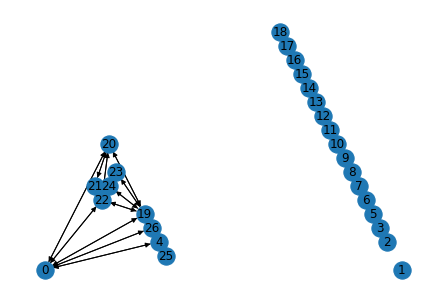

In [41]:
nx.draw_planar(X[0][0].to_networkx(), with_labels = True)